In [233]:
from mesa import Agent, Model
from mesa.time import RandomActivation, BaseScheduler
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, Point, MultiPoint, box
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp
from numpy.random import rand, seed
import folium
import random 
from haversine import haversine
import plotly.express as px
import base64
from io import BytesIO
from IPython.display import IFrame
pd.options.mode.chained_assignment = None  # default='warn'

In [430]:
class ConstructionSite(Agent): 
    def __init__(self, unique_id, model, buildingType, coords, inA10):
        super().__init__(unique_id, model)
        self.buildingType = buildingType # A, B, C...etc. 
        self.coords = coords 
        self.inA10 = inA10 # True or False 
        self.materials_request = {}
        self.materials_received = {}
        
        if self.model.hub_network == 'decentralized': 
            self.nearestMicroHub_id = 0 
            self.nearestMicroHub_dist = 0 
        self.nearestMacroHub_id = 0 
        self.nearestMacroHub_dist = 0 
        
        self.calc_materials_required()
            
    def calc_materials_required(self): 
        materials_required = {}
        b = self.model.build_info.copy()
        b = b[(b.buildingType == self.buildingType) & 
              (b.biobased == self.model.biobased_type)] 
        
        if self.model.modularity_type == 'none': 
            mat_list = self.model.materials_list.copy()
            mat_list.remove('modules')
            materials_required = dict.fromkeys(mat_list,0)
            for mat in mat_list: 
                for strucType in ['structural', 'nonstructural']: 
                    b1 = b[b.strucType == strucType]
                    materials_required[mat] += b1[mat].iloc[0]
        else: 
            mat_list = self.model.materials_list.copy() 
            materials_required = dict.fromkeys(mat_list,0)
            for mat in mat_list: 
                b1 = b[b.strucType == 'structural']
                materials_required[mat] += b1[mat].iloc[0]
                
        self.materials_required = materials_required
        self.materials_received = dict.fromkeys(materials_required.keys(), 0)
        
    def step(self): 
        self.list_materials_toRequest()
        self.request_materials()
    
    def list_materials_toRequest(self): 
        materials_toRequest = []
        for mat in self.materials_required.keys():  
            mat_required = self.materials_required[mat]
            mat_received = self.materials_received[mat]
            if mat_received < mat_required: 
                materials_toRequest.append(mat)
        self.materials_toRequest_list = materials_toRequest
        # if not materials_toRequest: 
        #     print(f'site {self.unique_id} has received all materials')
        
    def request_materials(self):
        material_request = {}
        for mat in self.materials_toRequest_list:
            mat_required = self.materials_required[mat]
            mat_received = self.materials_received[mat] 
            mat_stillNeeded = mat_required - mat_received
            mat_request = mat_required * random.uniform(0.1, 0.2)
            mat_request = mat_request if mat_request < mat_stillNeeded else mat_stillNeeded 
            material_request[mat] = mat_request
        self.materials_request = material_request
        
class Hub(Agent):
    def __init__(self, unique_id, model, hubType, coords, inA10):
        super().__init__(unique_id, model)
        self.hubType = hubType # macro or micro 
        self.coords = coords
        self.inA10 = inA10
        self.nearestMacroHub_id = None
        self.nearestMacroHub_dist = None
        
        self.materials_toSend = {}
        self.nTrips = {}
        self.materials_request = {}
        self.materials_received = dict.fromkeys(self.model.materials_list, 0)
        
        self.suppliers = {}
        self.clients = {}
        self.trucks_toSite = []
        self.vehicles_toSupplier = []
        self.demolition_site_ids = []
        self.supplier_ids = []
                                
    def step(self):
        self.find_clients()
        if self.clients: # if hub has clients: 
            self.calc_materials_toSend() # to each site / microHub
            self.make_materials_request() # for suppliers or macroHubs 
            if self.model.circularity_type == 'full' and self.hubType == 'macro': 
                self.collect_materials_fromDemolitionSites()
            self.find_suppliers()
            self.collect_materials_fromSupplier() # collect materials from suppliers / macroHub
            if self.model.hub_network == 'decentralized' and self.hubType == 'micro': 
                self.send_materials_toClient() 
            elif self.model.hub_network == 'centralized': 
                self.send_materials_toClient() 
        
    def find_clients(self): 
        '''self.clients = {id: {'agent': agentObject, 'distance': 14312}, ... etc}'''
        clients_dict = {} 
        if self.model.hub_network == 'decentralized': 
            if self.hubType == 'macro': 
                microHubs = [hub for hub in self.model.hubs if hub.hubType == 'micro']
                clients = [hub for hub in microHubs if hub.nearestMacroHub_id == self.unique_id]
                for client in clients: 
                    clients_dict[client.unique_id] = {'agent': client, 'distance': client.nearestMacroHub_dist}
            elif self.hubType == 'micro': 
                sites = self.model.construction_sites
                clients = [site for site in sites if site.nearestMicroHub_id == self.unique_id]
                for client in clients: 
                    clients_dict[client.unique_id] = {'agent': client, 'distance': client.nearestMicroHub_dist}
        elif self.model.hub_network == 'centralized': 
            sites = self.model.construction_sites
            clients = [site for site in sites if site.nearestMacroHub_id == self.unique_id]
            for client in clients: 
                clients_dict[client.unique_id] = {'agent': client, 'distance': client.nearestMacroHub_dist}
        self.clients = clients_dict
                
    def calc_materials_toSend(self): 
        '''self.materials_toSend = {site_id: {'timber': 123, 'concrete': 345}, ... etc}'''
        clients_dict = self.clients
        mat_to_send = {}
        for client_id in self.clients.keys():
            client = self.clients[client_id]['agent']
            if sum(client.materials_request.values()) > 0: 
                mat_to_send[client_id] = client.materials_request
        self.materials_toSend = mat_to_send
                
    def make_materials_request(self):
        '''self.materials_request = {'timber': 3421, 'concrete': 8723, 'modules': 13, ... etc}'''
        material_request = {}
        for site_id, mat_amounts in self.materials_toSend.items():
            for mat, amount in mat_amounts.items(): 
                try: 
                    material_request[mat] += amount 
                except: 
                    material_request[mat] = 0
                    material_request[mat] += amount 
        self.materials_request = material_request
        
    def collect_materials_fromDemolitionSites(self): 
        trucks = self.model.trucks_urban
        vehicle = [t for t in trucks if t.truck_type == self.model.truck_type][0]
        materials_collected = dict.fromkeys(self.materials_request.keys(), 0)
        for mat, request_tons in self.materials_request.items(): 
            if mat in self.model.demolition_sites_df.columns: 
                while True: 
                    demSites = self.model.demolition_sites_df
                    demSites = demSites[demSites.nearestHub_id == self.unique_id]
                    demSite = demSites.sample(1)
                    supply_tons = demSite[mat].iloc[0]
                    materials_collected[mat] += supply_tons

                    capacity = vehicle.capacity[mat]
                    emissions_perKm = vehicle.emissions_perKm 
                    distance = demSite.nearestHub_dist.iloc[0]
                    nTrips = math.ceil(supply_tons / capacity)
                    emissions = emissions_perKm * distance * nTrips * 2
                    self.model.emissions_s2h += emissions
                    self.demolition_site_ids.append(demSite.id.iloc[0])
                    
                    if materials_collected[mat] > request_tons: 
                        break
                        
        for mat, amount in materials_collected.items(): 
            self.materials_request[mat] -= amount 
            if self.materials_request[mat] < 0: 
                self.materials_request[mat] = 0
        
        temp = self.materials_request
        temp = {key: value for key, value in temp.items() if value != 0}
        self.materials_request = temp


    def find_suppliers(self): 
        '''self.suppliers = {'timber': {'agent': agentObject, 'distance': 14312}, ... etc}'''
        self.suppliers = {}
        for mat in self.materials_request.keys():
            self.suppliers[mat] = {}
            if self.hubType == 'macro': 
                supplier = [s for s in self.model.suppliers if s.material == mat][0]
                self.suppliers[mat]['agent'] = supplier 
                self.suppliers[mat]['distance'] = supplier.distance_fromAms
                self.supplier_ids.append(supplier.unique_id)
            elif self.hubType == 'micro': 
                macroHubs = [h for h in self.model.hubs if h.hubType == 'macro']
                supplier = [h for h in macroHubs if h.unique_id == self.nearestMacroHub_id][0]
                self.suppliers[mat]['agent'] = supplier
                self.suppliers[mat]['distance'] = self.nearestMacroHub_dist 
                self.supplier_ids.append(supplier.unique_id)
            
    def collect_materials_fromSupplier(self): 
        '''
        self.model.emissions_s2h (float) = emissions from vehicle going to supplier and back
        self.materials_received (dict) = {'timber': 123, 'concrete': 456 ... etc} 
        '''
        for mat, amount in self.materials_request.items(): 
            supplier = self.suppliers[mat]['agent']
            distance = self.suppliers[mat]['distance']
            if self.hubType == 'macro': 
                vehicle = self.model.vehicles_international[0]
            elif self.hubType == 'micro': 
                trucks = self.model.trucks_urban
                vehicle = [t for t in trucks if t.truck_type == self.model.truck_type][0]
            capacity = vehicle.capacity[mat]
            emissions_perKm = vehicle.emissions_perKm 
            nTrips = math.ceil(amount / capacity)
            
            self.model.emissions_s2h += emissions_perKm * distance * nTrips * 2
            self.materials_received[mat] += amount
        
    def send_materials_toClient(self): 
        trucks = self.model.trucks_urban
        truck = [t for t in trucks if t.truck_type == self.model.truck_type][0]
        emissions_perKm = truck.emissions_perKm
        
        for client_id, mat_amounts in self.materials_toSend.items(): 
            client = self.clients[client_id]['agent']
            distance = self.clients[client_id]['distance']
            for mat, amount in mat_amounts.items(): 
                capacity = truck.capacity[mat]
                nTrips = math.ceil(amount / capacity)
                emissions = emissions_perKm * distance * nTrips * 2
                
                self.model.emissions_h2c += emissions
                client.materials_received[mat] += amount
                                        
class Supplier(Agent): 
    def __init__(self, unique_id, model, material, distFromAms, coords): 
        super().__init__(unique_id, model)
        self.material = material
        self.distance_fromAms = distFromAms 
        self.coords = coords
        self.clients = {}
        
    def step(self): 
        self.find_clients() 
        if self.clients and self.model.hub_network == 'none': 
            self.calc_materials_toSend() 
            self.send_materials_toClient() 
    
    def find_clients(self): 
        '''self.clients = list of client agents [agent, agent, agent ...]'''
        self.clients = {}
        if self.model.hub_network == 'centralized': 
            clients = self.model.hubs
        elif self.model.hub_network == 'decentralized': 
            clients = [hub for hub in self.model.hubs if hub.hubType == 'macro']
        elif self.model.hub_network == 'none': 
            clients = [site for site in self.model.construction_sites]
        self.clients = clients 
                
    def calc_materials_toSend(self): 
        '''self.materials_toSend = {id: {'timber': 123, 'concrete': 456}, ... }'''
        self.materials_toSend = {}
        for client in self.clients: 
            client_id = client.unique_id
            mat_req = client.materials_request 
            if self.material in mat_req.keys(): 
                self.materials_toSend[client_id] = mat_req

    def send_materials_toClient(self): 
        for client_id, mat_amounts in self.materials_toSend.items(): 
            client = [c for c in self.clients if c.unique_id == client_id][0]
            distance = self.distance_fromAms
            vehicle = self.model.vehicles_international[0]
            emissions_perKm = vehicle.emissions_perKm
            for mat, amount in mat_amounts.items(): 
                capacity = vehicle.capacity[mat]
                nTrips = math.ceil(amount / capacity)
                emissions = emissions_perKm * distance * nTrips * 2
                
                self.model.emissions_s2h += emissions
                client.materials_received[mat] += amount
                            
class Truck_Urban(Agent):
    def __init__(self, unique_id, model, truck_type, capacity, emissions_perKm):
        super().__init__(unique_id, model)
        self.emissions = 0
        self.truck_type = truck_type
        self.capacity = capacity
        self.emissions_perKm = emissions_perKm
        
        self.loaded = False
        self.content = {} # {'material': amount}
        self.destination_id = None
        
    def step(self):
        pass
    
class Vehicle_International(Agent): 
    def __init__(self, unique_id, model, network_type, capacity, emissions_perKm): 
        super().__init__(unique_id, model)
        self.emissions = 0 
        self.network_type = network_type
        self.capacity = capacity
        self.emissions_perKm = emissions_perKm
        self.loaded = False
        self.content = {}
        
    def step(self): 
        pass 

In [434]:
from mesa import Model
from mesa.datacollection import DataCollector
class Model(Model):
    def __init__(self, parameters_dict): 
        '''create construction sites, hubs, and vehicles'''
        super().__init__()
        self.schedule = BaseScheduler(self)
        self.emissions_s2h = 0
        self.emissions_h2c = 0 
        self.datacollector = DataCollector(
            model_reporters = {
                'emissions_s2h': lambda m: m.emissions_s2h, 
                'emissions_h2c': lambda m: m.emissions_h2c, 
                'emissions_total': lambda m: m.emissions_s2h + m.emissions_h2c, 
            }
        )
        
        self.load_data()
        self.add_parameters(parameters_dict) 
        
        self.id_count = 0
        self.create_constructionSites()
        self.create_suppliers() 
        if self.hub_network != 'none': 
            self.create_hubs()
        self.create_trucks_urban()
        self.create_vehicles_international() 
        
        if self.hub_network != 'none': 
            self.create_od_matrix_h2c()
            self.create_od_matrix_h2h()
            self.assign_hubs_to_sites()
            self.assign_hubs_to_hubs()
        
        if self.circularity_type != 'none': 
            self.create_od_matrix_h2d()
            self.assign_hubs_to_demolition_sites()
                    
    def load_data(self): 
        self.construction_sites_df = gpd.read_file('data/data_cleaned/construction_sites.shp')
        self.hubs_df = gpd.read_file('data/data_cleaned/hubs.shp')
        self.suppliers_df = gpd.read_file('data/data_cleaned/suppliers.shp')
        self.demolition_sites_df = gpd.read_file('data/data_cleaned/demolition_sites.shp').sample(50)
        self.vehicles_info = pd.read_csv('data/data_cleaned/vehicles_info.csv')
        self.build_info = pd.read_csv('data/data_cleaned/buildingType_info.csv')
        self.materials_list = ['timber', 'concrete', 'modules']
        
        self.construction_sites = []
        self.hubs = []
        self.suppliers = []
        self.trucks_urban = []
        self.vehicles_international = []
        
    def add_parameters(self, parameters_dict): 
        self.network_type = parameters_dict['network_type']
        self.truck_type = parameters_dict['truck_type']
        self.biobased_type = parameters_dict['biobased_type']
        self.modularity_type = parameters_dict['modularity_type']
        self.hub_network = parameters_dict['hub_network']
        self.circularity_type = parameters_dict['circularity_type']
    
    def create_constructionSites(self): 
        for i, row in self.construction_sites_df.iterrows(): 
            coords = (row.geometry.y, row.geometry.x)
            site = ConstructionSite(self.id_count, self, row.buildType, 
                                    coords, row.inA10)
            self.schedule.add(site)
            self.construction_sites.append(site)
            self.id_count += 1 
    
    def create_hubs(self): 
        if self.hub_network == 'centralized': 
            hub_type = ['macro']
        elif self.hub_network == 'decentralized': 
            hub_type = ['micro', 'macro']
        elif self.hub_network == 'none': 
            hub_type = []
        for i, row in self.hubs_df.iterrows(): 
            if row.hub_type in hub_type: 
                coords = (row.geometry.y, row.geometry.x)
                hub = Hub(self.id_count, self, row.hub_type, coords, row.inA10)
                self.schedule.add(hub)
                self.hubs.append(hub)
                self.id_count += 1 
                
    def get_capacity(self, network_type, truck_type): 
        v = self.vehicles_info.copy()
        v = v[(v.transType == network_type) & (v.vehicleType == truck_type)]
        capacity_dict = {}
        for mat in self.materials_list + ['modules']: 
            capacity = v[f'capacity_{mat}'].iloc[0]
            capacity_dict[mat] = capacity
        emissions_perKm = v.emissions_perKm.iloc[0]
        return capacity_dict, emissions_perKm
    
    def create_trucks_urban(self): 
        # create urban trucks
        truckTypes = ['diesel', 'electric'] if self.truck_type == 'semi' else [self.truck_type]
        for truckType in truckTypes: 
            capacity_dict, emissions_perKm = self.get_capacity('road', truckType)
            truck_urban = Truck_Urban(
                self.id_count, self, self.truck_type, 
                capacity_dict, emissions_perKm)
            self.schedule.add(truck_urban)
            self.trucks_urban.append(truck_urban)
            self.id_count += 1  
            
    def create_vehicles_international(self): 
        if self.hub_network != 'none': 
            hub_ids = [hub.unique_id for hub in self.hubs]
        else: 
            # construction sites are considered 'hubs' if there is no hub_network
            hub_ids = [site.unique_id for site in self.construction_sites]
                    
        vehicle_type = 'diesel' if self.network_type == 'road' else self.network_type
        capacity_dict, emissions_perKm = self.get_capacity(self.network_type, vehicle_type)
        vehicle_international = Vehicle_International(
            self.id_count, self, self.network_type, 
            capacity_dict, emissions_perKm)
        self.schedule.add(vehicle_international)  
        self.vehicles_international.append(vehicle_international)
        self.id_count += 1 
    
    def create_suppliers(self): 
        for i, row in self.suppliers_df.iterrows(): 
            coords = (row.geometry.y, row.geometry.x)
            supplier = Supplier(self.id_count, self, row.material, 
                                row.distAms, coords)
            self.schedule.add(supplier)
            self.suppliers.append(supplier)
            self.id_count += 1
    
    def create_od_matrix_h2c(self): 
        self.od_matrix_h2c = []
        for site in self.construction_sites: 
            for hub in self.hubs: 
                distance = haversine(site.coords, hub.coords)
                self.od_matrix_h2c.append([hub.unique_id, site.unique_id, distance])
        self.od_matrix_h2c = np.array(self.od_matrix_h2c)
    
    def create_od_matrix_h2h(self): 
        self.od_matrix_h2h = []
        macroHubs = [hub for hub in self.hubs if hub.hubType == 'macro']
        for macroHub in macroHubs: 
            for hub in self.hubs: 
                distance = haversine(macroHub.coords, hub.coords)
                self.od_matrix_h2h.append([macroHub.unique_id, hub.unique_id, distance])
        self.od_matrix_h2h = np.array(self.od_matrix_h2h)
        
    def create_od_matrix_h2d(self): 
        self.od_matrix_h2d = []
        macroHubs = [hub for hub in self.hubs if hub.hubType == 'macro']
        for macroHub in macroHubs: 
            for unique_id, row in self.demolition_sites_df.iterrows(): 
                demSite_coords = (row.geometry.y, row.geometry.x)
                distance = haversine(macroHub.coords, demSite_coords)
                self.od_matrix_h2d.append([macroHub.unique_id, unique_id, distance])
        self.od_matrix_h2d = np.array(self.od_matrix_h2d)
                
    def assign_hubs_to_sites(self):
        od = self.od_matrix_h2c
        nMacroHubs = len([hub for hub in self.hubs if hub.hubType == 'macro'])
        for site in self.construction_sites: 
            site_od = od[od[:, 1] == site.unique_id]
            if self.hub_network == 'decentralized': 
                site_od_micro = site_od[nMacroHubs+1:]
                site.nearestMicroHub_id = int(site_od_micro[np.argmin(site_od_micro[:, 2]), 0])
                site.nearestMicroHub_dist = site_od_micro[np.argmin(site_od_micro[:, 2]), 2]
            site_od_macro = site_od[:nMacroHubs]
            site.nearestMacroHub_id = int(site_od_macro[np.argmin(site_od_macro[:, 2]), 0])
            site.nearestMacroHub_dist = site_od_macro[np.argmin(site_od_macro[:, 2]), 2]
                        
    def assign_hubs_to_hubs(self): 
        od = self.od_matrix_h2h
        for hub in self.hubs: 
            hub_od = od[od[:, 1] == hub.unique_id]
            hub.nearestMacroHub_id = int(hub_od[np.argmin(hub_od[:, 2])][0])
            hub.nearestMacroHub_dist = hub_od[np.argmin(hub_od[:, 2])][2]
            
    def assign_hubs_to_demolition_sites(self): 
        od = self.od_matrix_h2d
        def func(row): 
            unique_id = row.id
            site_od = od[od[:, 1] == unique_id]
            row['nearestHub_id'] = int(site_od[np.argmin(site_od[:, 2]), 0])
            row['nearestHub_dist'] = site_od[np.argmin(site_od[:, 2]), 2]
            return row
        self.demolition_sites_df = self.demolition_sites_df.apply(lambda row: func(row), axis=1)
            
    def step(self):
        self.schedule.step()
        self.calc_emissions()
        self.datacollector.collect(self)
    
    def calc_emissions(self): 
        self.emissions = round(self.emissions_h2c + self.emissions_s2h)
    
    def visualize(self): 
        self.save_folium_html()
        self.display_total_emissions()
        self.display_emissions_chart()
        self.display_folium_html() 
    
    def save_folium_html(self): 
        
        m = folium.Map([52.377231, 4.899288], zoom_start=11, tiles='cartodbdark_matter')
        if self.hub_network != 'none': 
            self.plotLines_h2c(m) 
            if self.circularity_type != 'none': 
                self.plotLines_d2h(m)
                self.plotPoints_demSites(m, 'pink', 1)
        self.plotLines_s2h(m)
        self.plotPoints(m, self.suppliers, 'pink', 1)
        self.plotPoints(m, [hub for hub in self.hubs if hub.hubType == 'micro'], 'red', 1)
        self.plotPoints(m, [hub for hub in self.hubs if hub.hubType == 'macro'], 'red', 5)
        self.plotPoints(m, self.construction_sites, 'white', 1)
        m.save('temp_map_hubs.html')
    
    def display_total_emissions(self): 
        total_emissions = round(self.emissions_h2c + self.emissions_s2h)
        print(f'emissions (hubs to construction sites): {round(self.emissions_h2c)} tCO2eq')
        print(f'emissions (suppliers to hubs): {round(self.emissions_s2h)} tCO2eq')
        print(f'emissions (total): {total_emissions} tCO2eq')
        
    def display_emissions_chart(self): 
        data = self.datacollector.get_model_vars_dataframe()
        data = data.reset_index(names='step')
        fig = px.line(data, x="step", 
                      y=['emissions_s2h', 'emissions_h2c', 'emissions_total'], 
                      title='emissions')
        return fig.show()
    
    def display_folium_html(self): 
        display(IFrame("temp_map_hubs.html", width=700, height=600))
 
    
    def plotPoints(self, m, agent_list, color, radius): 
        for coord in [agent.coords for agent in agent_list]: 
            folium.CircleMarker(
                location=coord, radius=radius, color=color
            ).add_to(m)

    def plotLines_h2c(self, m): 
        for hub in self.hubs: 
            coords_hub = hub.coords
            for site_id in hub.clients.keys(): 
                coords_site = list(hub.clients[site_id]['agent'].coords)
                folium.PolyLine(
                    locations=[coords_site, coords_hub], weight=1, 
                    color='grey', dash_array='5'
                ).add_to(m)
                
    def plotLines_s2h(self, m): 
        if self.hub_network != 'none': 
            hubs = [hub for hub in self.hubs if hub.hubType == 'macro']
            for hub in hubs: 
                for supplier_id in hub.supplier_ids: 
                    supplier = [s for s in self.suppliers if s.unique_id == supplier_id][0]
                    folium.PolyLine(
                        locations=[supplier.coords, hub.coords], weight=1, 
                        color='#454545', dash_array='5'
                    ).add_to(m)
        else: 
            sites = self.construction_sites
            for supplier in self.suppliers: 
                for site in sites: 
                    folium.PolyLine(
                        locations=[supplier.coords, site.coords], weight=1, 
                        color='#454545', dash_array='5'
                    ).add_to(m)
                
    def plotLines_d2h(self, m):
        for hub in self.hubs: 
            coords_hub = hub.coords
            demSite_ids = list(set(hub.demolition_site_ids))
            for demSite_id in demSite_ids:
                demSite = self.demolition_sites_df.loc[demSite_id]
                coord_demSite = (demSite.geometry.y, demSite.geometry.x)
                folium.PolyLine(
                    locations=[coords_hub, coord_demSite], weight=1, 
                    color='#454545', dash_array='5'
                ).add_to(m)
        
    def plotPoints_demSites(self, m, color, radius): 
        for hub in self.hubs: 
            demSite_ids = list(set(hub.demolition_site_ids))
            for demSite_id in demSite_ids: 
                demSite = self.demolition_sites_df.loc[demSite_id]
                coord = (demSite.geometry.y, demSite.geometry.x)
                folium.CircleMarker(
                    location=coord, radius=radius, color=color
                ).add_to(m)

In [409]:
import ipywidgets as widgets
from IPython.display import display

# Define your parameters and their options
params_options = {
    'hub_network': ['none', 'centralized', 'decentralized'],
    'network_type': ['road', 'roadWater', 'rail'],
    'truck_type': ['diesel', 'semi', 'electric'],
    'biobased_type': ['none', 'semi', 'full'],
    'modularity_type': ['none', 'full'], 
    'circularity_type': ['none', 'full']
}

# Create dropdown widgets
dropdowns = {}
for key, options in params_options.items():
    dropdowns[key] = widgets.Dropdown(options=options, description=key, value=options[0])
    display(dropdowns[key])

Dropdown(description='hub_network', options=('none', 'centralized', 'decentralized'), value='none')

Dropdown(description='network_type', options=('road', 'roadWater', 'rail'), value='road')

Dropdown(description='truck_type', options=('diesel', 'semi', 'electric'), value='diesel')

Dropdown(description='biobased_type', options=('none', 'semi', 'full'), value='none')

Dropdown(description='modularity_type', options=('none', 'full'), value='none')

Dropdown(description='circularity_type', options=('none', 'full'), value='none')

emissions (hubs to construction sites): 68 tCO2eq
emissions (suppliers to hubs): 750 tCO2eq
emissions (total): 819 tCO2eq


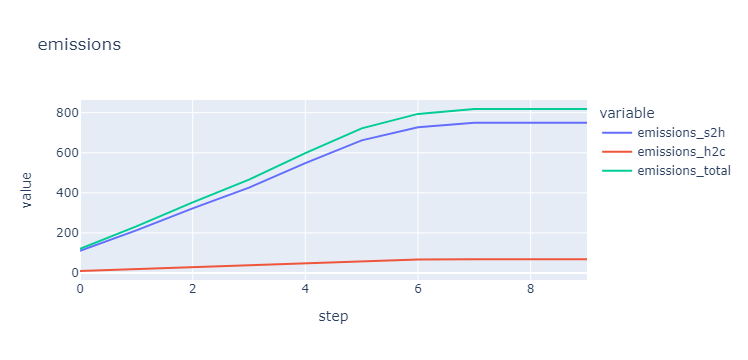

In [437]:
parameters_dict = {}
for name in dropdowns.keys(): 
    parameters_dict[name] = dropdowns[name].value

# create and run model 
model = Model(parameters_dict)
for i in range(10): 
    model.step()

model.visualize()

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output, IFrame
import folium

# Create an output widget to handle the display within the notebook
out = widgets.Output()

# Function to be triggered
def on_button_click(b):
    with out:
        clear_output(wait=True)  # Clear the previous output
        
        parameters_dict = {}
        for name in dropdowns.keys(): 
            parameters_dict[name] = dropdowns[name].value

        # create and run model 
        model = Model(parameters_dict)
        for i in range(10): 
            model.step()

        # visualize results 
        model.visualize()
        
        # Display the folium map using IFrame
        display(IFrame(src=model.iframe, width=700, height=400))
        
        # You can add other outputs like plotly plots or more printed text here

# Create the button
button = widgets.Button(description="Run Model")
button.on_click(on_button_click)

# Display the button and the output widget
display(button, out)


Button(description='Run Model', style=ButtonStyle())

Output()